# Project 2 - Coronavirus in China


This project consist to estimate the SIR model with the most updated data from WHO.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PDEparams as pde
import cufflinks as cf
import plotly
import os
import math
import sympy as sy
from scipy import integrate
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, median_absolute_error
from scipy.integrate import odeint
from scipy.optimize import differential_evolution, minimize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from scipy.integrate import odeint
print(__version__) # requires version >= 1.9.0

4.5.4


In [2]:
path = 'figsModelsChina'
if not os.path.isdir(path): os.makedirs(path)

In [3]:
# Saving figures
def save_fig(fig,figname):
    fig.savefig(os.path.join(path,figname+'.pdf'),format='pdf')

In [4]:
# Complete Database
data=pd.read_csv('CoV2019.csv')

In [5]:
china = data["China"][:27]
days = data["Days"][:27]
total = data["Total"][:27]
deaths_china = data["Death China"][:27]
other = data["Other"]
china_total = data["China"]
days_total = data["Days"]
deaths_china_total = data["Death China"]
deaths_outside_total = data["Death Outside"]


In [6]:
incidence_china=[data['China'][1]-data['China'][0]]
#incidence_china=[china[0]]
for i in range(1,data.shape[0]):
    incidence_china.append(data['China'][i]-data['China'][i-1])
data['incidence_china']=incidence_china

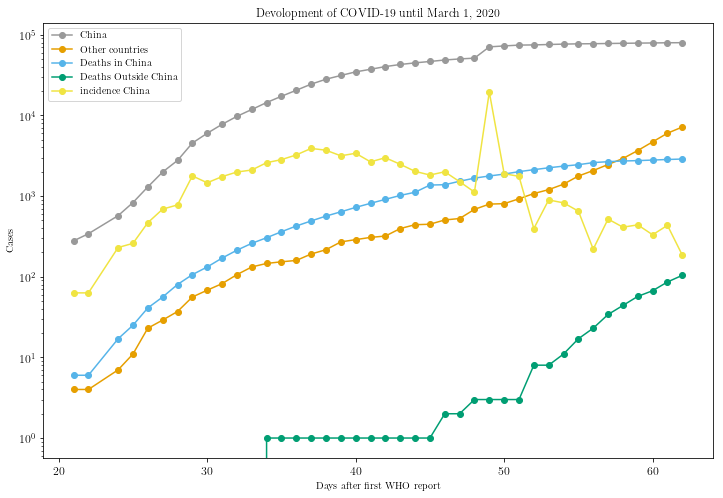

In [7]:
#Plotting data
plt.figure(figsize=(12, 8))
plt.title("Devolopment of COVID-19 until March 1, 2020")
plt.plot(days_total, china_total, '-o', label="China")
plt.plot(days_total, other, '-o', label="Other countries")
plt.plot(days_total, deaths_china_total, '-o', label="Deaths in China")
plt.plot(days_total, deaths_outside_total, '-o', label="Deaths Outside China")
plt.plot(days_total, data['incidence_china'], '-o', label="incidence China")
plt.yscale('log')
plt.ylabel("Cases")
plt.xlabel("Days after first WHO report")
plt.legend()

In [8]:
data=data.drop(27, axis=0)

In [9]:
tdf=range(len(data['incidence_china']))
df=pd.DataFrame({'t':tdf,'I':data['incidence_china']/(10**4)},columns=['t','I'])

In [10]:
#For ploting
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

### Initial conditions

In [11]:
def init_s():
    return 1-init_i()

def init_sd():
    return 0

def init_e():
    return 0
    
def init_a():
    return 0

def init_id():
    return 0

def init_i():
    return df['I'][0]

def init_r():
    return 0


### 1. SIR model:

$$\begin{align}
\frac{\mathrm{d} S}{\mathrm{d} t} &= -\beta\, \frac{SI}{N}\\
\frac{\mathrm{d} I}{\mathrm{d} t} &= \beta\, \frac{SI}{N} - \gamma\,I\\
\frac{\mathrm{d} R}{\mathrm{d} t} &= \gamma\,I
\end{align}$$


Susceptible -> Infected -> Recovered

$$\begin{align}
\beta &= \text{Contact Rate } \times \text{ Probability of Transmission}\\
\sigma &= \text{Incubation Rate}\\
\gamma &= \text{Recovery Rate}
\end{align}$$

Incubation Period: 1-14 Days, most commonly 5 days (WHO)

In [12]:
#Model
def sir(X,t,b,g):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i
    dr=g*i
    return[ds,di,dr]

def sirm(X,t,b,g,m):
    s,i,r=X
    
    ds=-b*(s*i)
    di=b*(s*i)-g*i-m*i
    dr=g*i
    return[ds,di,dr]

In [13]:
#Numeric solution of the model
def sol_sir(init,t,b,g):
    sol=odeint(sir,init,t,args=(b,g))
    return(sol)

def sol_sirm(init,t,b,g,m):
    sol=odeint(sirm,init,t,args=(b,g,m))
    return(sol)

In [14]:
#Parameter estimation
my_sir=pde.PDEmodel(df,sir,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5)],
                   param_names=[r'$b$', r'$g$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [15]:
#Parameter estimation
my_sirm=pde.PDEmodel(df,sirm,[init_s,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$g$',r'$m$'], nvars=3, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [16]:
my_sir.fit()

        $b$      $g$
0  0.553752  0.16148


In [17]:
my_sirm.fit()

        $b$       $g$       $m$
0  0.553689  0.072271  0.089193


In [18]:
my_sir.best_params

,$b$,$g$
0,0.553752,0.16148


In [19]:
my_sirm.best_params


,$b$,$g$,$m$
0,0.553689,0.072271,0.089193


In [20]:
my_sir.best_error

0.0008692698089231649

In [21]:
my_sirm.best_error

0.0008692711284783198

In [22]:
bestPars_sir=my_sir.best_params
bBsir=bestPars_sir['$b$'][0]
gBsir=bestPars_sir['$g$'][0]

In [23]:
bestPars_sirm=my_sirm.best_params
bBsirm=bestPars_sirm['$b$'][0]
gBsirm=bestPars_sirm['$g$'][0]
mBsirm=bestPars_sirm['$m$'][0]

In [24]:
bestSol=odeint(sir,[init_s(),init_i(),init_r()],tdf,args=(bBsir,gBsir))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
S=bestSol.T[0]
I=bestSol.T[1]
R=bestSol.T[2]


In [25]:
bestSolm=odeint(sirm,[init_s(),init_i(),init_r()],tdf,args=(bBsirm,gBsirm,mBsirm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sm=bestSolm.T[0]
Im=bestSolm.T[1]
Rm=bestSolm.T[2]


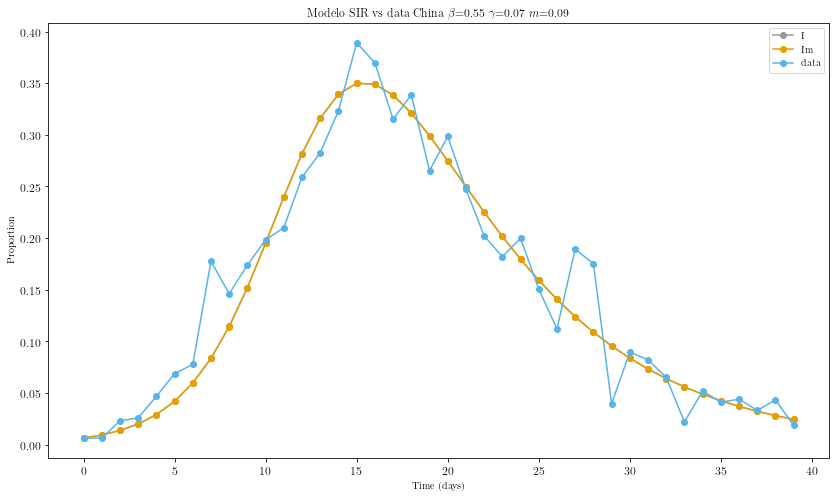

In [26]:
fig1,ax1=plt.subplots(1,1,figsize=(14,8))
ax1.plot(tdf,I,'-o',label='I')
ax1.plot(tdf,Im,'-o',label='Im')
ax1.plot(tdf,df['I'],'-o',label='data')
ax1.set_title('Modelo SIR vs data China '+r'$\beta$='+r'%0.2f'%bBsirm+ r' $\gamma$='+r'%0.2f'%gBsirm+r' $m$='+r'%0.2f'%mBsirm)
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Proportion')
ax1.legend()

### 2. SEIR model (Latency)

In [27]:
def seir(X,t,b,eta,g):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i
    dr=g*i
    return[ds,de,di,dr]

def seirm(X,t,b,eta,g,m):
    s,e,i,r=X
    
    ds=-b*(s*i)
    de=b*(s*i)-eta*e
    di=eta*e-g*i-m*i
    dr=g*i
    return[ds,de,di,dr]

In [28]:
def sol_seir(init,t,b,eta,g):
    sol=odeint(seir,init,t,args=(b,eta,g))
    return(sol)

def sol_seirm(init,t,b,eta,g,m):
    sol=odeint(seirm,init,t,args=(b,eta,g,m))
    return(sol)

In [29]:
my_seir=pde.PDEmodel(df,seir,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5)],
                   param_names=[r'$b$', r'$eta$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [30]:
my_seirm=pde.PDEmodel(df,seirm,[init_s,init_e,init_i,init_r],bounds=[(0.3,2),(1/14,1/5),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$b$', r'$eta$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [31]:
%%time
my_seir.fit()

   $b$  $eta$       $g$
0  2.0    0.2  0.169548
Wall time: 2 s


In [32]:
%%time
my_seirm.fit()

   $b$  $eta$       $g$       $m$
0  2.0    0.2  0.089261  0.080286
Wall time: 4.09 s


In [33]:
my_seir.best_params

,$b$,$eta$,$g$
0,2.0,0.2,0.169548


In [34]:
my_seirm.best_params

,$b$,$eta$,$g$,$m$
0,2.0,0.2,0.089261,0.080286


In [35]:
my_seir.best_error

0.0011505247373651373

In [36]:
my_seirm.best_error

0.0011505247374073134

In [37]:
bestPars_seir=my_seir.best_params
bBseir=bestPars_seir['$b$'][0]
eBseir=bestPars_seir['$eta$'][0]
gBseir=bestPars_seir['$g$'][0]

In [38]:
bestPars_seirm=my_seirm.best_params
bBseirm=bestPars_seirm['$b$'][0]
eBseirm=bestPars_seirm['$eta$'][0]
gBseirm=bestPars_seirm['$g$'][0]
mBseirm=bestPars_seirm['$m$'][0]

In [39]:
bestSol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseir,eBseir,gBseir))
Sseir=bestSol_seir.T[0]
Eseir=bestSol_seir.T[1]
Iseir=bestSol_seir.T[2]
Rsair=bestSol_seir.T[3]

In [40]:
bestSol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],tdf,args=(bBseirm,eBseirm,gBseirm,mBseirm))
Sseirm=bestSol_seirm.T[0]
Eseirm=bestSol_seirm.T[1]
Iseirm=bestSol_seirm.T[2]
Rseirm=bestSol_seirm.T[3]



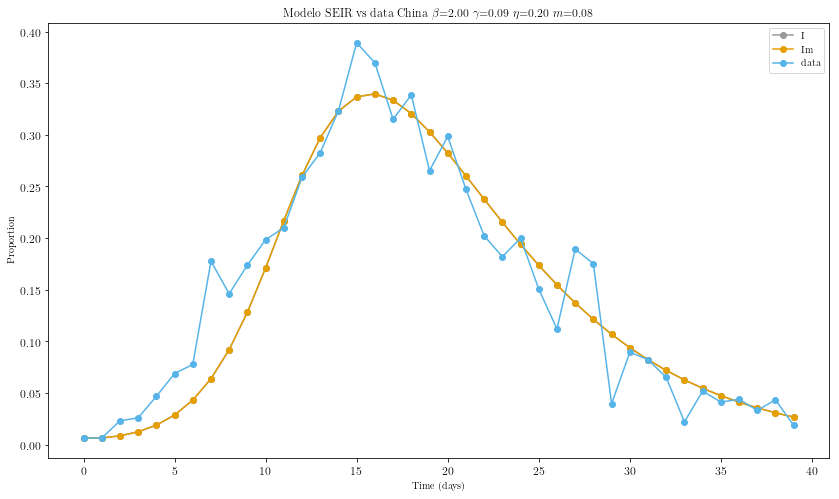

In [41]:
fig2,ax2=plt.subplots(1,1,figsize=(14,8))
ax2.plot(tdf,Iseir,'-o',label='I')
ax2.plot(tdf,Iseirm,'-o',label='Im')
ax2.plot(tdf,df['I'],'-o',label='data')
ax2.set_title('Modelo SEIR vs data China '+r'$\beta$='+r'%0.2f'%bBseirm+ r' $\gamma$='+r'%0.2f'%gBseirm+r' $\eta$='+r'%0.2f'%eBseirm+r' $m$='+r'%0.2f'%mBseirm)
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Proportion')
ax2.legend()

### 3. SAIR (Assymptomatic)

In [42]:
def sair(X,t,ba,bi,p,g):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i
    dr=g*i+g*a
    return[ds,da,di,dr]

def sairm(X,t,ba,bi,p,g,m):
    s,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    da=p*(ba*a*s+bi*i*s)-g*a
    di=(1-p)*(ba*a*s+bi*i*s)-g*i-m*i
    dr=g*i+g*a
    return[ds,da,di,dr]


In [43]:
def sol_sair(init,t,ba,bi,p,g):
    sol=odeint(sair,init,t,args=(ba,bi,p,g))
    return(sol)

def sol_sairm(init,t,ba,bi,p,g,m):
    sol=odeint(sair,init,t,args=(ba,bi,p,g,m))
    return(sol)

In [44]:
my_sair=pde.PDEmodel(df,sair,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [45]:
my_sairm=pde.PDEmodel(df,sairm,[init_s,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [46]:
%%time
my_sair.fit()

   $ba$      $bi$  $p$      $g$
0   0.3  0.576249  0.1  0.14528
Wall time: 4.44 s


In [47]:
%%time
my_sairm.fit()

       $ba$      $bi$       $p$       $g$       $m$
0  0.300531  0.574186  0.100002  0.104054  0.040939
Wall time: 7.9 s


In [48]:
my_sair.best_params

,$ba$,$bi$,$p$,$g$
0,0.3,0.576249,0.1,0.14528


In [49]:
my_sairm.best_params

,$ba$,$bi$,$p$,$g$,$m$
0,0.300531,0.574186,0.100002,0.104054,0.040939


In [50]:
my_sair.best_error

0.0008739044427245565

In [51]:
my_sairm.best_error

0.000876422656070044

In [52]:
bestPars_sair=my_sair.best_params
baBsair=bestPars_sair['$ba$'][0]
biBsair=bestPars_sair['$bi$'][0]
pBsair=bestPars_sair['$p$'][0]
gBsair=bestPars_sair['$g$'][0]

In [53]:
bestPars_sairm=my_sairm.best_params
baBsairm=bestPars_sairm['$ba$'][0]
biBsairm=bestPars_sairm['$bi$'][0]
pBsairm=bestPars_sairm['$p$'][0]
gBsairm=bestPars_sairm['$g$'][0]
mBsairm=bestPars_sairm['$m$'][0]

In [54]:
bestSol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsair,biBsair,pBsair,gBsair))
Ssair=bestSol_sair.T[0]
Asair=bestSol_sair.T[1]
Isair=bestSol_sair.T[2]
Rsair=bestSol_sair.T[3]

In [55]:
bestSol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],tdf,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
Ssairm=bestSol_sairm.T[0]
Asairm=bestSol_sairm.T[1]
Isairm=bestSol_sairm.T[2]
Rsairm=bestSol_sairm.T[3]


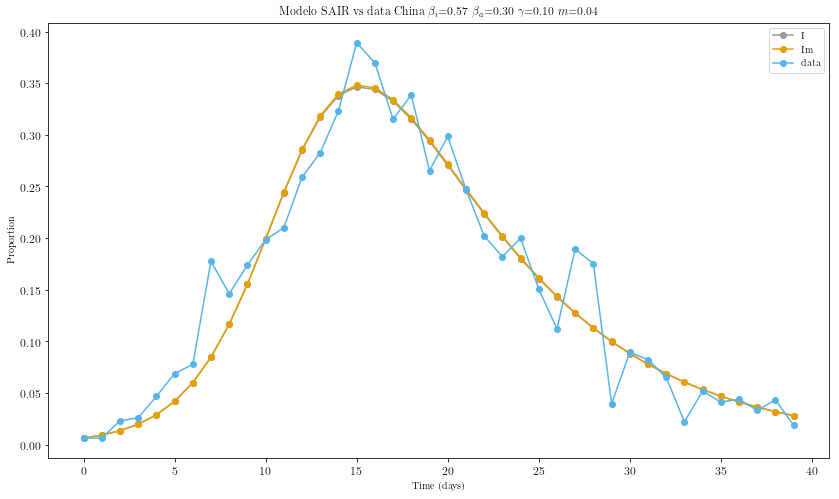

In [56]:
fig3,ax3=plt.subplots(1,1,figsize=(14,8))
ax3.plot(tdf,Isair,'-o',label='I')
ax3.plot(tdf,Isairm,'-o',label='Im')
ax3.plot(tdf,df['I'],'-o',label='data')
ax3.set_title('Modelo SAIR vs data China '+r'$\beta_i$='+r'%0.2f'%biBsairm+ r' $\beta_a$='+r'%0.2f'%baBsairm+r' $\gamma$='+r'%0.2f'%gBsairm+r' $m$='+r'%0.2f'%mBsairm)
ax3.set_xlabel('Time (days)')
ax3.set_ylabel('Proportion')
ax3.legend()

### 4. SEAIR 

In [57]:
def seair(X,t,ba,bi,eta,p,g):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]


def seairm(X,t,ba,bi,eta,p,g,m):
    s,e,a,i,r=X
    
    ds=-(ba*a+bi*i)*s
    de=(ba*a+bi*i)*s-eta*e
    da=p*eta*e-g*a
    di=(1-p)*eta*e-g*i-m*i
    dr=g*i+g*a
    return[ds,de,da,di,dr]

In [58]:
def sol_seair(init,t,ba,bi,eta,p,g):
    sol=odeint(seair,init,t,args=(ba,bi,eta,p,g))
    return(sol)

def sol_seairm(init,t,ba,bi,eta,p,g,m):
    sol=odeint(seairm,init,t,args=(ba,bi,eta,p,g,m))
    return(sol)

In [59]:
my_seair=pde.PDEmodel(df,seair,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [60]:
my_seairm=pde.PDEmodel(df,seairm,[init_s,init_e,init_a,init_i,init_r],bounds=[(0.3,2),(0.3,2),(1/14,1/5),(0.1,0.9),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$ba$', r'$bi$',r'$eta$',r'$p$',r'$g$',r'$m$'], nvars=5, ndims=0, nreplicates=1, obsidx=[3], outfunc=None)

In [61]:
%%time
my_seair.fit()

   $ba$  $bi$  $eta$  $p$       $g$
0   2.0   2.0    0.2  0.1  0.151462
Wall time: 9.19 s


In [62]:
%%time
my_seairm.fit()

   $ba$  $bi$  $eta$  $p$       $g$       $m$
0   2.0   2.0    0.2  0.1  0.071429  0.080201
Wall time: 23.6 s


In [63]:
my_seair.best_params

,$ba$,$bi$,$eta$,$p$,$g$
0,2.0,2.0,0.2,0.1,0.151462


In [64]:
my_seairm.best_params

,$ba$,$bi$,$eta$,$p$,$g$,$m$
0,2.0,2.0,0.2,0.1,0.071429,0.080201


In [65]:
my_seair.best_error

0.001263998829273558

In [66]:
my_seairm.best_error

0.0012315781360459437

In [67]:
bestPars_seair=my_seair.best_params
baBseair=bestPars_seair['$ba$'][0]
biBseair=bestPars_seair['$bi$'][0]
eBseair=bestPars_seair['$eta$'][0]
pBseair=bestPars_seair['$p$'][0]
gBseair=bestPars_seair['$g$'][0]

In [68]:
bestPars_seairm=my_seairm.best_params
baBseairm=bestPars_seairm['$ba$'][0]
biBseairm=bestPars_seairm['$bi$'][0]
eBseairm=bestPars_seairm['$eta$'][0]
pBseairm=bestPars_seairm['$p$'][0]
gBseairm=bestPars_seairm['$g$'][0]
mBseairm=bestPars_seairm['$m$'][0]

In [69]:
bestSol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
Sseair=bestSol_seair.T[0]
Eseair=bestSol_seair.T[1]
Aseair=bestSol_seair.T[2]
Iseair=bestSol_seair.T[3]
Rseair=bestSol_seair.T[4]


In [70]:
bestSol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],tdf,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
#sol=odeint(sir,[shortMex.sum(axis=0),1,0],tMex,args=(bB,gB))
Sseairm=bestSol_seairm.T[0]
Eseairm=bestSol_seairm.T[1]
Aseairm=bestSol_seairm.T[2]
Iseairm=bestSol_seairm.T[3]
Rseairm=bestSol_seairm.T[4]

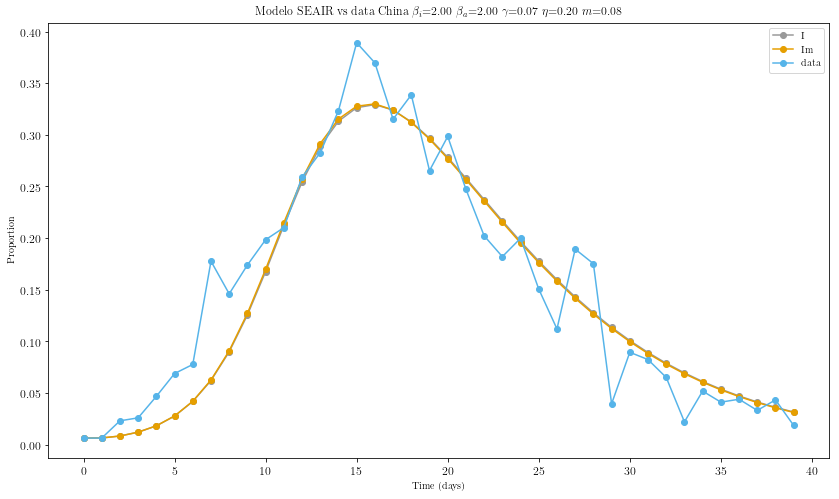

In [71]:
fig4,ax4=plt.subplots(1,1,figsize=(14,8))
ax4.plot(tdf,Iseair,'-o',label='I')
ax4.plot(tdf,Iseairm,'-o',label='Im')
ax4.plot(tdf,df['I'],'-o',label='data')
ax4.set_title('Modelo SEAIR vs data China '+r'$\beta_i$='+r'%0.2f'%biBseairm+ r' $\beta_a$='+r'%0.2f'%baBseairm+r' $\gamma$='+r'%0.2f'%gBseairm+r' $\eta$='+r'%0.2f'%eBseairm+r' $m$='+r'%0.2f'%mBseairm)
ax4.set_xlabel('Time (days)')
ax4.set_ylabel('Proportion')
ax4.legend()

### 5. SDIR 

In [72]:
def sdir(X,t,bi,p,g):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-g*I
    dR=g*I
    return[dS,dSD,dI,dR]

def sdirm(X,t,bi,p,g,m):
    S,SD,I,R=X
    
    dS=-(bi*I)*S
    dSD=-p*(bi*I)*SD
    dI=(bi*I)*S+p*(bi*I)*SD-(g+m)*I
    dR=g*I
    return[dS,dSD,dI,dR]

In [73]:
def sol_sdir(init,t,bi,p,g):
    sol=odeint(sdir,init,t,args=(bi,p,g))
    return(sol)

def sol_sdirm(init,t,bi,p,g,m):
    sol=odeint(sdir,init,t,args=(bi,p,g,m))
    return(sol)

In [74]:
my_sdir=pde.PDEmodel(df,sdir,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5)],
                   param_names=[r'$bi$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [75]:
my_sdirm=pde.PDEmodel(df,sdirm,[init_s,init_sd,init_i,init_r],bounds=[(0.3,2),(1,2),(1/14,1/5),(0.001,0.3)],
                   param_names=[r'$bi$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[2], outfunc=None)

In [76]:
%%time
my_sdir.fit()

       $bi$       $p$       $g$
0  0.553747  1.619615  0.161481
Wall time: 968 ms


In [77]:
%%time
my_sdirm.fit()

       $bi$       $p$       $g$       $m$
0  0.553751  1.274943  0.096356  0.065123
Wall time: 1.97 s


In [78]:
my_sdir.best_params

,$bi$,$p$,$g$
0,0.553747,1.619615,0.161481


In [79]:
my_sdirm.best_params

,$bi$,$p$,$g$,$m$
0,0.553751,1.274943,0.096356,0.065123


In [80]:
my_sdir.best_error

0.0008692698231552708

In [81]:
my_sdirm.best_error

0.0008692698204145865

In [82]:
bestPars_sdir=my_sdir.best_params
biBsdir=bestPars_sdir['$bi$'][0]
pBsdir=bestPars_sdir['$p$'][0]
gBsdir=bestPars_sdir['$g$'][0]

In [83]:
bestPars_sdirm=my_sdirm.best_params
biBsdirm=bestPars_sdirm['$bi$'][0]
pBsdirm=bestPars_sdirm['$p$'][0]
gBsdirm=bestPars_sdirm['$g$'][0]
mBsdirm=bestPars_sdirm['$m$'][0]

In [84]:
bestSol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdir,pBsdir,gBsdir))
Ssdir=bestSol_sdir.T[0]
SDsdir=bestSol_sdir.T[1]
Isdir=bestSol_sdir.T[2]
Rsdir=bestSol_sdir.T[3]

In [85]:
bestSol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],tdf,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
Ssdirm=bestSol_sdirm.T[0]
SDsdirm=bestSol_sdirm.T[1]
Isdirm=bestSol_sdirm.T[2]
Rsdirm=bestSol_sdirm.T[3]

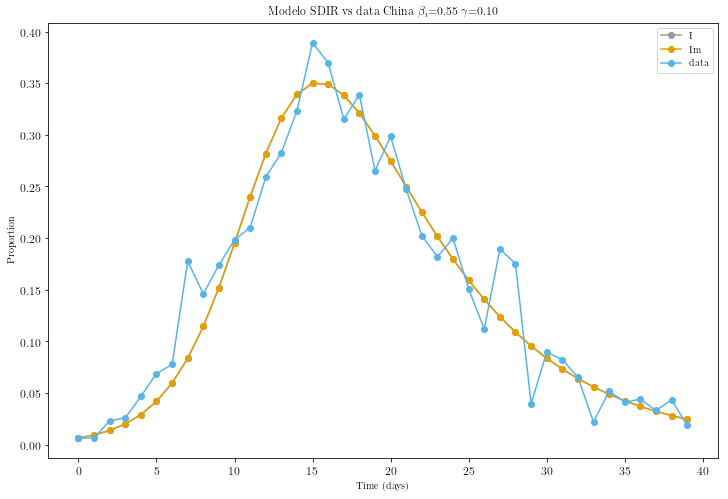

In [86]:
fig5,ax5=plt.subplots(1,1,figsize=(12,8))
ax5.plot(tdf,Isdir,'-o',label='I')
ax5.plot(tdf,Isdirm,'-o',label='Im')
ax5.plot(tdf,df['I'],'-o',label='data')
ax5.set_title('Modelo SDIR vs data China '+r'$\beta_i$='+r'%0.2f'%biBsdirm+r' $\gamma$='+r'%0.2f'%gBsdirm)
ax5.set_xlabel('Time (days)')
ax5.set_ylabel('Proportion')
ax5.legend()

### 6. SIGR

In [87]:
def sigr(X,t,bi,bg,p,g):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]

def sigrm(X,t,bi,bg,p,g,m):
    S,I,IG,R=X
    
    dS=-(bi*I+bg*IG)*S
    dI=(1-p)*(bi*I+bg*IG)*S-g*I
    dIG=p*(bi*I+bg*IG)*S-g*IG-m*IG
    dR=g*I+g*IG
    return[dS,dI,dIG,dR]


In [88]:
def sol_sigr(init,t,bi,bg,p,g):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g))
    return(sol)

def sol_sigrm(init,t,bi,bg,p,g,m):
    sol=odeint(sigr,init,t,args=(bi,bg,p,g,m))
    return(sol)

In [89]:
my_sigr=pde.PDEmodel(df,sigr,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [90]:
my_sigrm=pde.PDEmodel(df,sigrm,[init_s,init_i,init_id,init_r],bounds=[(0.3,2),(0.3,2),(0.1,0.9),(1/14,1/5),(1/100,1/4)],
                   param_names=[r'$bi$', r'$bg$',r'$p$',r'$g$',r'$m$'], nvars=4, ndims=0, nreplicates=1, obsidx=[1], outfunc=None)

In [91]:
%%time
my_sigr.fit()

       $bi$      $bg$  $p$       $g$
0  0.576076  0.301314  0.1  0.145285
Wall time: 6.44 s


In [92]:
%%time
my_sigrm.fit()

       $bi$  $bg$  $p$       $g$   $m$
0  0.584305   0.3  0.1  0.144587  0.25
Wall time: 5.23 s


In [93]:
my_sigr.best_params

,$bi$,$bg$,$p$,$g$
0,0.576076,0.301314,0.1,0.145285


In [94]:
my_sigrm.best_params

,$bi$,$bg$,$p$,$g$,$m$
0,0.584305,0.3,0.1,0.144587,0.25


In [95]:
my_sigr.best_error

0.0008739633023616749

In [96]:
my_sigrm.best_error

0.0008678447627532511

In [97]:
bestPars_sigr=my_sigr.best_params
biBsigr=bestPars_sigr['$bi$'][0]
bgBsigr=bestPars_sigr['$bg$'][0]
pBsigr=bestPars_sigr['$p$'][0]
gBsigr=bestPars_sigr['$g$'][0]

In [98]:
bestPars_sigrm=my_sigrm.best_params
biBsigrm=bestPars_sigrm['$bi$'][0]
bgBsigrm=bestPars_sigrm['$bg$'][0]
pBsigrm=bestPars_sigrm['$p$'][0]
gBsigrm=bestPars_sigrm['$g$'][0]
mBsigrm=bestPars_sigrm['$m$'][0]

In [99]:
bestSol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigr,bgBsigr,pBsigr,gBsigr))
Ssigr=bestSol_sigr.T[0]
Isigr=bestSol_sigr.T[1]
IGsigr=bestSol_sigr.T[2]
Rsigr=bestSol_sigr.T[3]

In [100]:
bestSol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],tdf,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))
Ssigrm=bestSol_sigrm.T[0]
Isigrm=bestSol_sigrm.T[1]
IGsigrm=bestSol_sigrm.T[2]
Rsigrm=bestSol_sigrm.T[3]



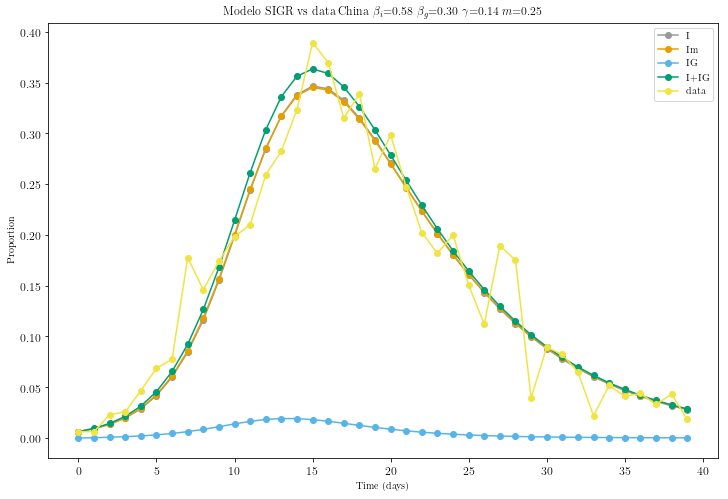

In [101]:
fig6,ax6=plt.subplots(1,1,figsize=(12,8))
ax6.plot(tdf,Isigr,'-o',label='I')
ax6.plot(tdf,Isigrm,'-o',label='Im')
ax6.plot(tdf,IGsigrm,'-o',label='IG')
ax6.plot(tdf,Isigrm+IGsigrm,'-o',label='I+IG')
ax6.plot(tdf,df['I'],'-o',label='data')
ax6.set_title('Modelo SIGR vs data China '+r'$\beta_i$='+r'%0.2f'%biBsigrm+r' $\beta_g$='+r'%0.2f'%bgBsigrm+r' $\gamma$='+r'%0.2f'%gBsigrm+r' $m$='+r'%0.2f'%mBsigrm)
ax6.set_xlabel('Time (days)')
ax6.set_ylabel('Proportion')
ax6.legend()

## Comparing approaches

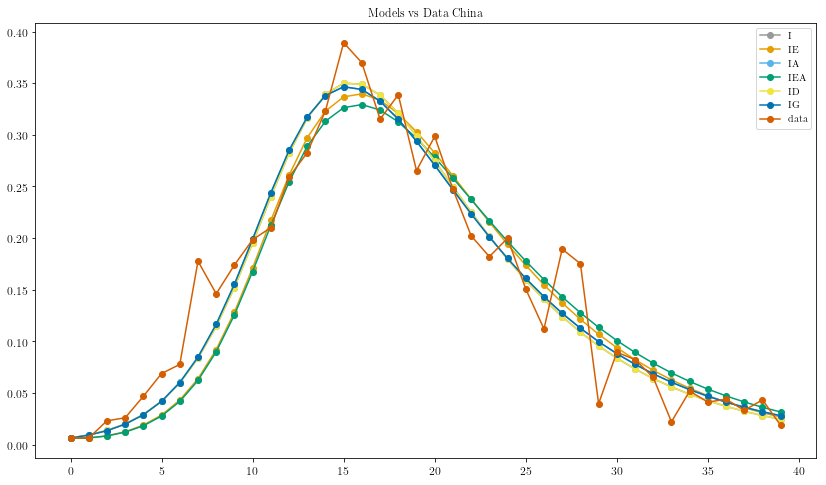

In [102]:
#Without mortality
figAll,axAll=plt.subplots(1,1,figsize=(14,8))
axAll.set_title('Models vs Data China')
axAll.plot(tdf,I,'-o', label="I")
axAll.plot(tdf,Iseir,'-o', label="IE")
axAll.plot(tdf,Isair,'-o', label="IA")
axAll.plot(tdf,Iseair,'-o', label="IEA")
axAll.plot(tdf,Isdir,'-o', label="ID")
axAll.plot(tdf,Isigr,'-o', label="IG")
axAll.plot(tdf,df['I'],'-o', label="data")
axAll.legend(loc='best')

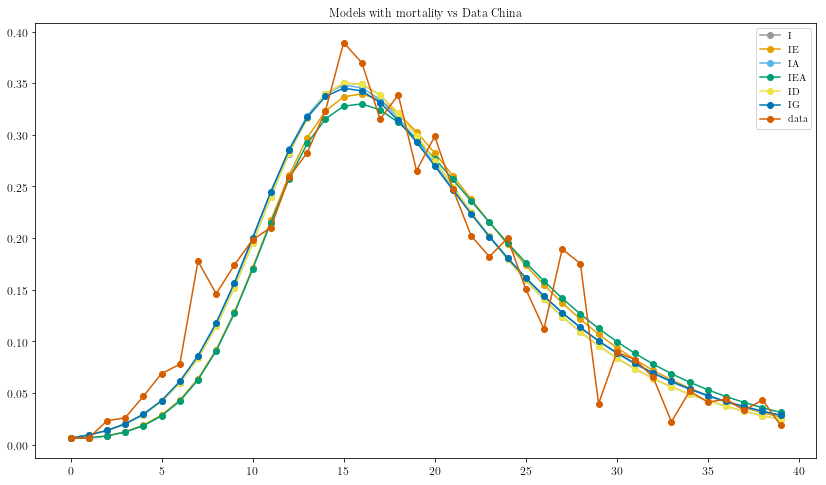

In [103]:
#With mortality
figAllm,axAllm=plt.subplots(1,1,figsize=(14,8))
axAllm.set_title('Models with mortality vs Data China')
axAllm.plot(tdf,Im,'-o', label="I")
axAllm.plot(tdf,Iseirm,'-o', label="IE")
axAllm.plot(tdf,Isairm,'-o', label="IA")
axAllm.plot(tdf,Iseairm,'-o', label="IEA")
axAllm.plot(tdf,Isdirm,'-o', label="ID")
axAllm.plot(tdf,Isigrm,'-o', label="IG")
axAllm.plot(tdf,df['I'],'-o', label="data")
axAllm.legend(loc='best')

## Comparing solutions of models

In [104]:
# Without mortality
t1=np.arange(0,50,1)

sol_sir=odeint(sir,[init_s(),init_i(),init_r()],t1,args=(bBsir,gBsir))
sol_seir=odeint(seir,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseir,eBseir,gBseir))
sol_sair=odeint(sair,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsair,biBsair,pBsair,gBsair))
sol_seair=odeint(seair,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseair,biBseair,eBseair,pBseair,gBseair))
sol_sdir=odeint(sdir,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdir,pBsdir,gBsdir))
sol_sigr=odeint(sigr,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigr,bgBsigr,pBsigr,gBsigr))


I1sir=sol_sir.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seir=sol_seir.T[2]
I1sair=sol_sair.T[2]
I1seair=sol_seair.T[3]
I1sdir=sol_sdir.T[2]
I1sigr=sol_sigr.T[1]

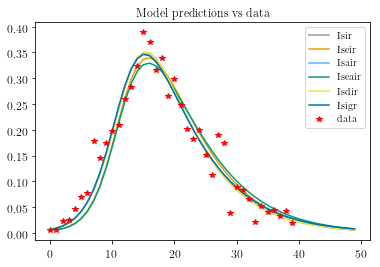

In [105]:
solsi=[I1sir,I1seir,I1sair,I1seair,I1sdir,I1sigr]
sol_labels=['Isir','Iseir','Isair','Iseair','Isdir','Isigr']

for soli,i in zip(solsi,range(len(solsi))):
    plt.plot(soli,label=sol_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Model predictions vs data')
plt.savefig(os.path.join(path,'predictions'+'.pdf'),format='pdf')

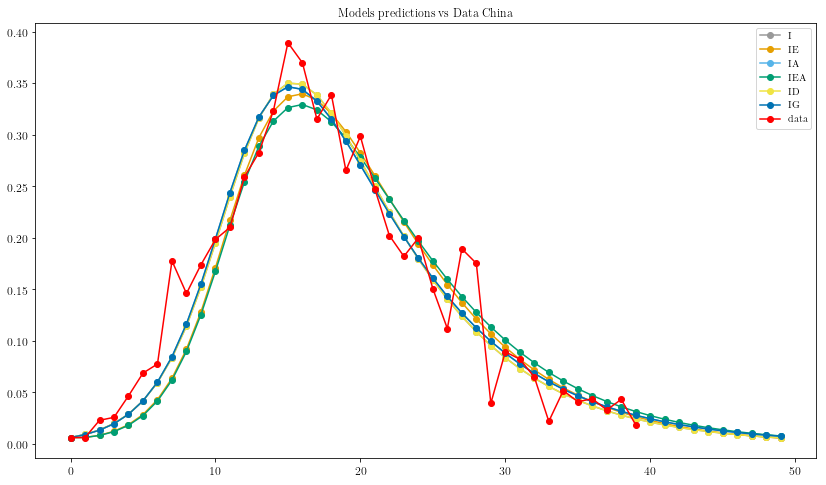

In [106]:
figAllP,axAllP=plt.subplots(1,1,figsize=(14,8))
axAllP.set_title('Models predictions vs Data China')
axAllP.plot(I1sir,'-o', label="I")
axAllP.plot(I1seir,'-o', label="IE")
axAllP.plot(I1sair,'-o', label="IA")
axAllP.plot(I1seair,'-o', label="IEA")
axAllP.plot(I1sdir,'-o', label="ID")
axAllP.plot(I1sigr,'-o', label="IG")
axAllP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllP.legend(loc='best')

In [107]:
#With mortality
t1=np.arange(0,50,1)

sol_sirm=odeint(sirm,[init_s(),init_i(),init_r()],t1,args=(bBsirm,gBsirm,mBsirm))
sol_seirm=odeint(seirm,[init_s(),init_e(),init_i(),init_r()],t1,args=(bBseirm,eBseirm,gBseirm,mBseirm))
sol_sairm=odeint(sairm,[init_s(),init_a(),init_i(),init_r()],t1,args=(baBsairm,biBsairm,pBsairm,gBsairm,mBsairm))
sol_seairm=odeint(seairm,[init_s(),init_e(),init_a(),init_i(),init_r()],t1,args=(baBseairm,biBseairm,eBseairm,pBseairm,gBseairm,mBseairm))
sol_sdirm=odeint(sdirm,[init_s(),init_sd(),init_i(),init_r()],t1,args=(biBsdirm,pBsdirm,gBsdirm,mBsdirm))
sol_sigrm=odeint(sigrm,[init_s(),init_i(),init_id(),init_r()],t1,args=(biBsigrm,bgBsigrm,pBsigrm,gBsigrm,mBsigrm))


I1sirm=sol_sirm.T[1]
#1sir_gm=sol_sir_gm.T[1]
I1seirm=sol_seirm.T[2]
I1sairm=sol_sairm.T[2]
I1seairm=sol_seairm.T[3]
I1sdirm=sol_sdirm.T[2]
I1sigrm=sol_sigrm.T[1]

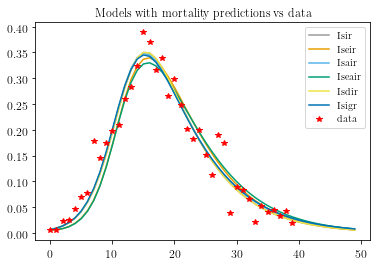

In [108]:
solsim=[I1sirm,I1seirm,I1sairm,I1seairm,I1sdirm,I1sigrm]
solm_labels=['Isir','Iseir','Isair','Iseair','Isdir','Isigr']

for solim,i in zip(solsim,range(len(solsi))):
    plt.plot(solim,label=solm_labels[i])
plt.plot(tdf,df['I'],'*',label='data',color='r')
plt.legend()
plt.title('Models with mortality predictions vs data')
plt.savefig(os.path.join(path,'predictionsMortality'+'.pdf'),format='pdf')

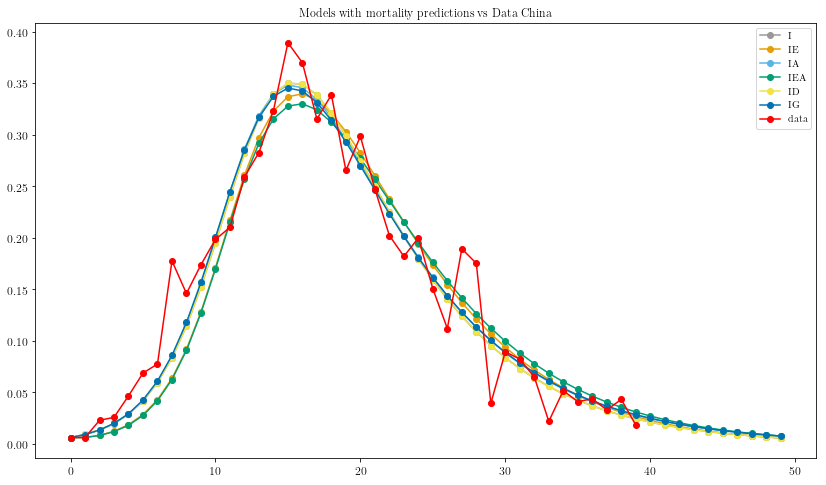

In [109]:
figAllmP,axAllmP=plt.subplots(1,1,figsize=(14,8))
axAllmP.set_title('Models with mortality predictions vs Data China')
axAllmP.plot(I1sirm,'-o', label="I")
axAllmP.plot(I1seirm,'-o', label="IE")
axAllmP.plot(I1sairm,'-o', label="IA")
axAllmP.plot(I1seairm,'-o', label="IEA")
axAllmP.plot(I1sdirm,'-o', label="ID")
axAllmP.plot(I1sigrm,'-o', label="IG")
axAllmP.plot(tdf,df['I'],'-o', color='r',label="data")
axAllmP.legend(loc='best')

### AIC MODEL COMPARISON

In [110]:
RSSv = [] 
RSSv = np.zeros(6)
AICv = []
AICv = np.zeros(6)

In [111]:
infec_sols=[Im,Iseirm,Isairm,Iseairm,Isdirm,Isigrm]
coef=[3,4,5,6,4,5]

In [112]:
for i,j in zip(infec_sols,range(len(infec_sols))):
        RSSv[j]=0.5*np.sum((df['I']-i)**2)
        AICv[j]=len(df['I'])*math.log10(RSSv[j]/len(df['I']))+ 2*coef[j]*len(df['I'])/(len(df['I'])-coef[j]-1)

In [113]:
grade = np.argmin(AICv)+1

In [114]:
AICv

array([-127.80832294, -120.46250425, -122.56795011, -113.87726647,
       -125.33215861, -122.73881207])

In [115]:
def aic_order(aics):
    aics_ordered=sorted(aics)
    
    list_index=dict()
    
    for i in range(len(aics)):
        #list_index['d'+r'%0.f'%i]=aics.index([dist_ordered[i]])
        list_index['d'+r'%0.f'%i]=np.where(aics==aics_ordered[i])
    
    return(aics_ordered,list_index)

In [116]:
(aic_order(AICv))

([-127.80832294259629,
  -125.33215860716999,
  -122.73881206659853,
  -122.56795011157045,
  -120.46250424925239,
  -113.87726646675544],
 {'d0': (array([0], dtype=int32),),
  'd1': (array([4], dtype=int32),),
  'd2': (array([5], dtype=int32),),
  'd3': (array([2], dtype=int32),),
  'd4': (array([1], dtype=int32),),
  'd5': (array([3], dtype=int32),)})

In [117]:
figs=[fig1,fig2,fig3,fig4,fig5,fig6,figAllP,figAllmP]
labels=['fig1','fig2','fig3','fig4','fig5','fig6','figAllP','figAllmP']

In [118]:
for fig,l in zip(figs,range(len(figs))):
    save_fig(fig,labels[l])
    